# Local-Global-Trend(LGT) Example

In [2]:
import pandas as pd
import numpy as np
from orbit.models.lgt import LGTMAP, LGTAggregated, LGTFull
from orbit.diagnostics.plot import plot_predicted_data
from orbit.diagnostics.plot import plot_predicted_components

## Data

*iclaims_example* is a dataset containing the weekly initial claims for US unemployment benefits against a few related google trend queries from Jan 2010 - June 2018. This aims to mimick the dataset from the paper "Predicting the Present with Bayesian Structural Time Series" by SCOTT and VARIAN (2014).

Number of claims are obtained from [Federal Reserve Bank of St. Louis](https://fred.stlouisfed.org/series/ICNSA) while google queries are obtained through [Google Trends API](https://trends.google.com/trends/?geo=US).

In [3]:
DATA_FILE = "./data/iclaims_example.csv"

In [4]:
raw_df = pd.read_csv(DATA_FILE, parse_dates=['week'])

In [5]:
raw_df.dtypes

week              datetime64[ns]
claims                     int64
trend.unemploy           float64
trend.filling            float64
trend.job                float64
dtype: object

In [6]:
raw_df.head(5)

,week,claims,trend.unemploy,trend.filling,trend.job
0,2010-01-03,651215,1.183973,0.720140,1.119669
1,2010-01-10,825891,1.183973,0.814896,1.178599
2,2010-01-17,659173,1.203382,0.739091,1.119669
3,2010-01-24,507651,1.164564,0.814896,1.107883
4,2010-01-31,538617,1.086926,0.776993,1.072525


### Train / Test Split

In [7]:
df=raw_df.copy()
test_size=52
train_df=df[:-test_size]
test_df=df[-test_size:]

In [8]:
train_df.head(5)

,week,claims,trend.unemploy,trend.filling,trend.job
0,2010-01-03,651215,1.183973,0.720140,1.119669
1,2010-01-10,825891,1.183973,0.814896,1.178599
2,2010-01-17,659173,1.203382,0.739091,1.119669
3,2010-01-24,507651,1.164564,0.814896,1.107883
4,2010-01-31,538617,1.086926,0.776993,1.072525


## MAP Fit and Predict

In [9]:
lgt_map=LGTMAP(
    response_col="claims",
    date_col="week",
    seasonality=52,
    seed=8888,
    is_multiplicative=True
)

In [10]:
%%time
lgt_map.fit(df=train_df)

CPU times: user 202 ms, sys: 8.57 ms, total: 210 ms
Wall time: 748 ms


In [11]:
predicted_df = lgt_map.predict(df=test_df)

In [12]:
predicted_df.tail(3)

,week,prediction
49,2018-06-10,210768.660527
50,2018-06-17,204083.919065
51,2018-06-24,213757.966094


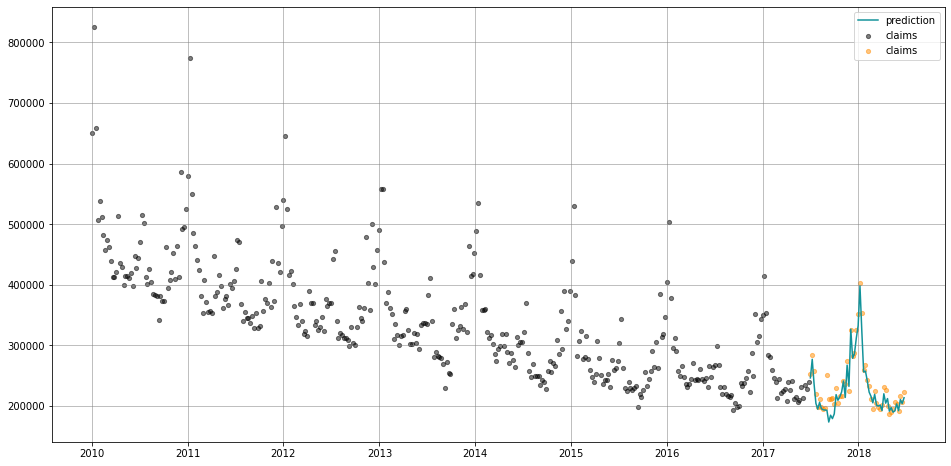

In [13]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=lgt_map.date_col, actual_col=lgt_map.response_col, pred_col='prediction', 
                    test_actual_df=test_df)

In [14]:
# test_df.head(5)

## MCMC Fit and Predict

In [15]:
lgt = LGTFull(
    response_col='claims',
    date_col='week',
    seasonality=52,
    seed=8888,
    num_warmup=4000, 
    num_sample=500,
    n_bootstrap_draws=-1,
)

In [16]:
%%time
lgt.fit(df=train_df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 111 ms, sys: 128 ms, total: 238 ms
Wall time: 19.4 s


In [17]:
predicted_df = lgt.predict(df=df)

In [18]:
predicted_df.tail(3)

,week,prediction
440,2018-06-10,213580.878788
441,2018-06-17,205999.778748
442,2018-06-24,213735.509892


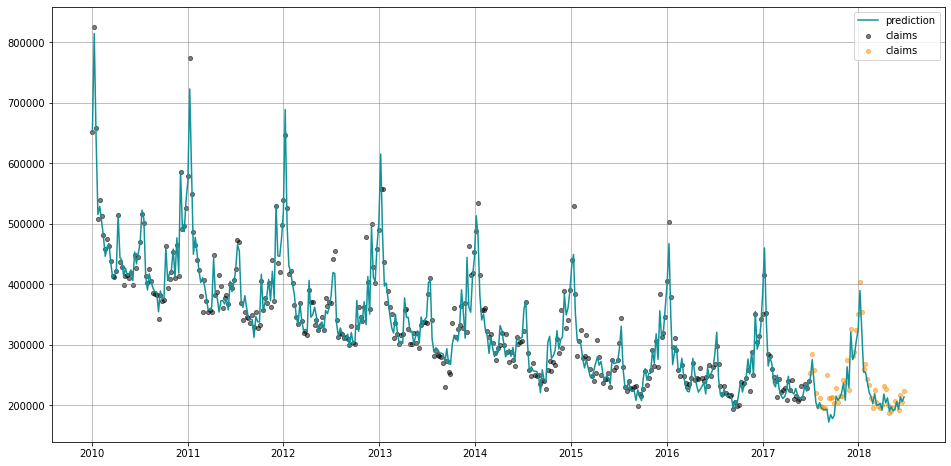

In [19]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=lgt.date_col, actual_col=lgt.response_col, pred_col='prediction', 
                    test_actual_df=test_df)

## Mean Fit

In [20]:
lgt_agg=LGTAggregated(
    response_col='claims',
    date_col='week',
    seasonality=52,
    seed=8888,
    num_warmup=4000, 
    num_sample=500,
)

In [21]:
%%time
lgt_agg.fit(df=train_df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 127 ms, sys: 131 ms, total: 258 ms
Wall time: 20.1 s


In [22]:
predicted_df = lgt_agg.predict(df=test_df)

In [23]:
predicted_df.tail(3)

,week,prediction
49,2018-06-10,204508.336558
50,2018-06-17,197939.615006
51,2018-06-24,207243.294808


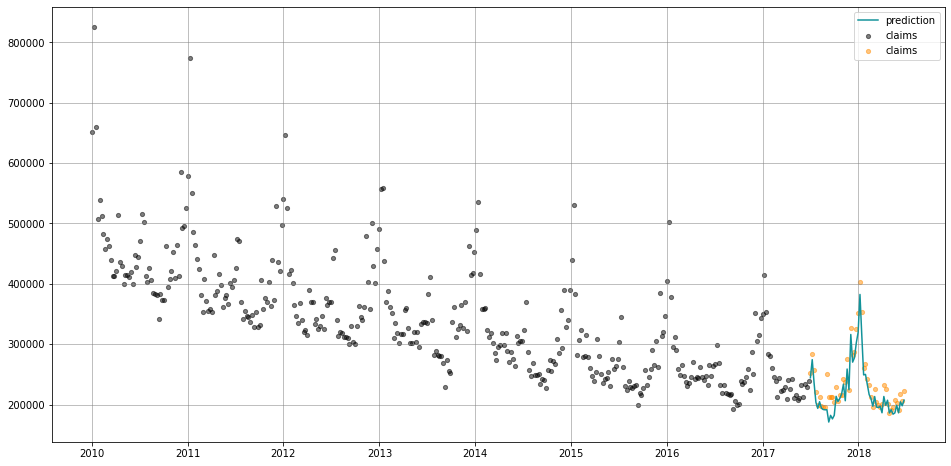

In [24]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=lgt_agg.date_col, actual_col=lgt_agg.response_col, pred_col='prediction', 
                    test_actual_df=test_df)

## Fit with Regressors & Predict with Decomp

### Fit with Regressors

In [25]:
lgt_reg=LGTMAP(
    response_col='claims',
    regressor_col=['trend.unemploy', 'trend.filling'],
    date_col='week',
    seasonality=52,
    seed=8888,
)

In [26]:
%%time
lgt_reg.fit(df=train_df)

CPU times: user 235 ms, sys: 7.59 ms, total: 243 ms
Wall time: 268 ms


### Decompose Prediction

We can use `decompose=True` to decompose prediction into `trend`, `seasonality` and `regression` components. This command only works with point estimate.

In [27]:
# make prediction of past and future
predicted_df = lgt_reg.predict(df=df, decompose=True)
predicted_df.head(3)

,week,prediction,trend,seasonality,regression
0,2010-01-03,651215.000000,495112.233665,1.338887,0.982374
1,2010-01-10,826299.875361,483633.563736,1.722757,0.991739
2,2010-01-17,650861.224696,481969.863706,1.370932,0.985037


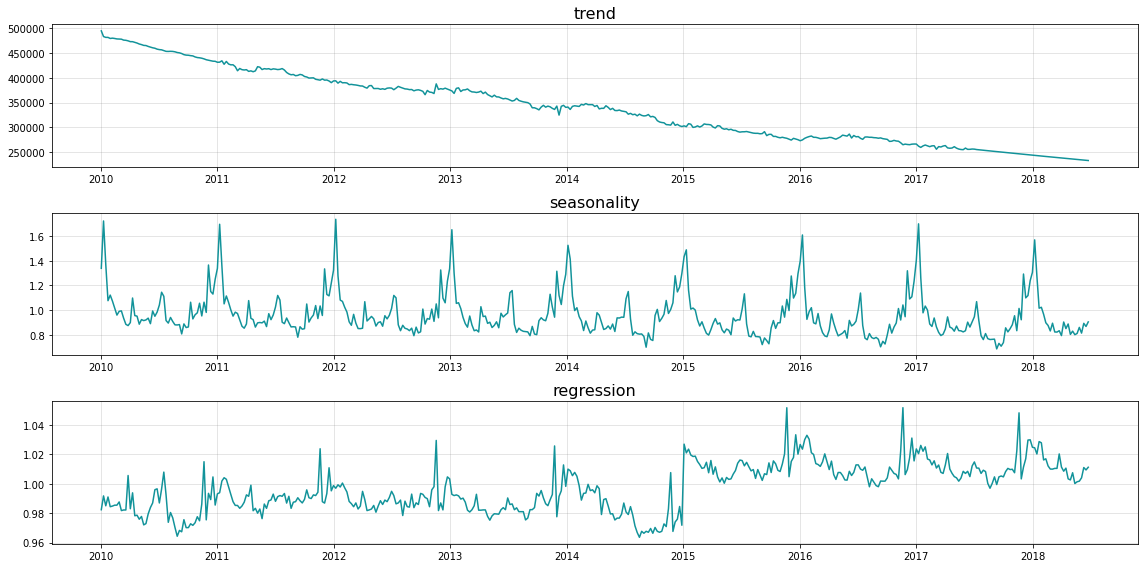

In [28]:
plot_predicted_components(predicted_df=predicted_df, date_col='week')